# Download Data From SEt50, GOLD, OIL

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


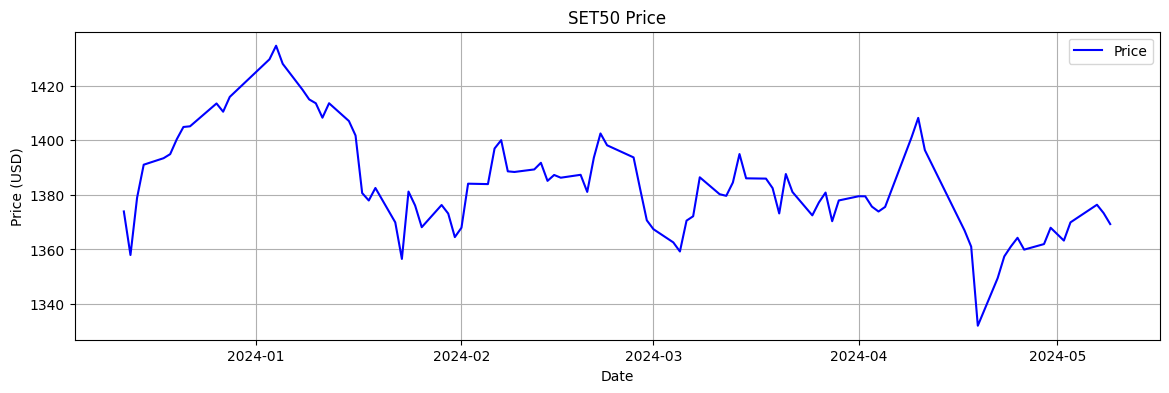

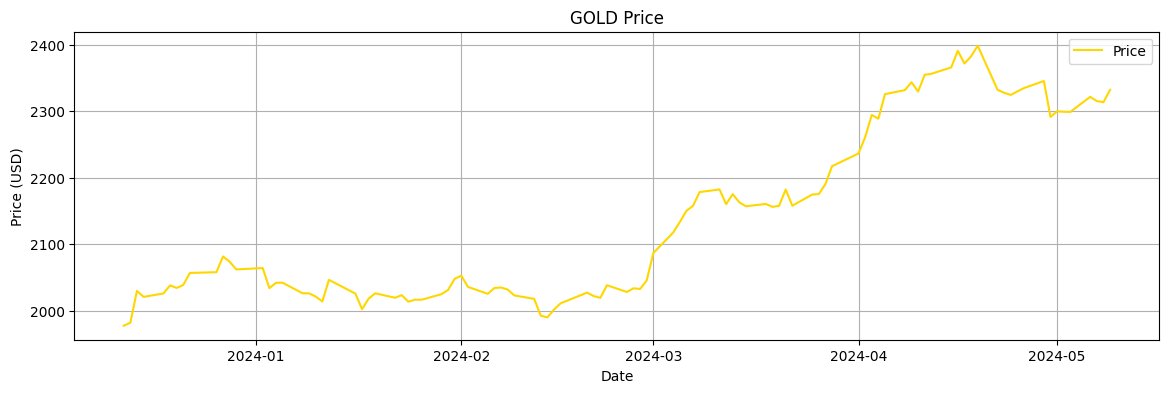

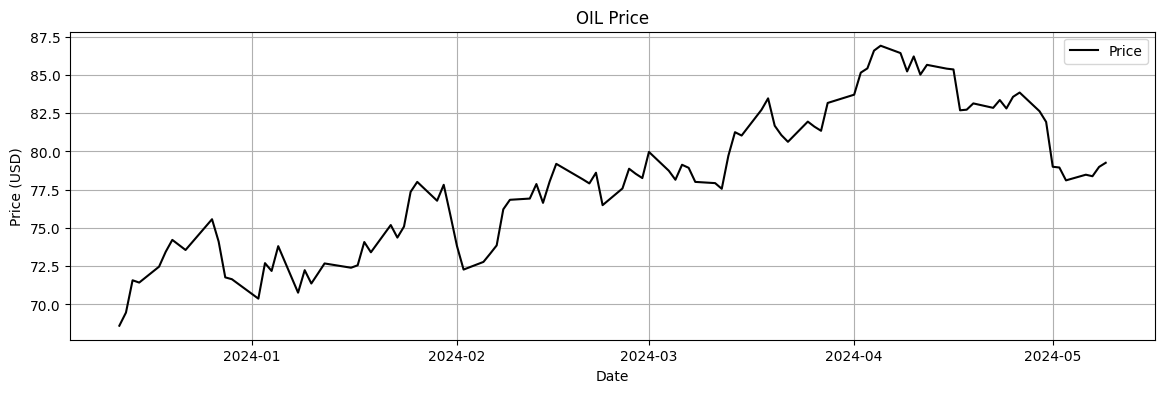

In [130]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

#set date
end_date = '2024-05-10'
start_date = pd.to_datetime(end_date)-pd.DateOffset(30*5)

SET50 = yf.download("^SET.BK", start = start_date, end = end_date)
GOLD = yf.download("GC=F", start = start_date, end = end_date)
OIL = yf.download("CL=F", start = start_date, end = end_date)
#show graph
def plot_show(data,set_color,set_title):
    # Plotting
    plt.figure(figsize=(14, 4))
    plt.plot(data['Close'], label='Price', color=set_color)
    plt.title(set_title)
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_show(SET50, 'blue', 'SET50 Price')
plot_show(GOLD, 'gold', 'GOLD Price')
plot_show(OIL, 'black', 'OIL Price')

# Preprocess Data (use only close price)

In [131]:
import pandas as pd
# Preprocess data SET50
dataset = SET50.copy()
dataset = dataset.reset_index()
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset.set_index('Date', inplace=True)
SET50 = dataset['Close'].to_frame()

# Preprocess data GOLD
dataset_gold = GOLD.copy()
dataset_gold = dataset_gold.reset_index()
dataset_gold['Date'] = pd.to_datetime(dataset_gold['Date'])
dataset_gold.set_index('Date', inplace=True)
GOLD = dataset_gold['Close'].to_frame()

# Preprocess data OIL
dataset_oil = OIL.copy()
dataset_oil = dataset_oil.reset_index()
dataset_oil['Date'] = pd.to_datetime(dataset_oil['Date'])
dataset_oil.set_index('Date', inplace=True)
OIL = dataset_oil['Close'].to_frame()


# Prepare LSTM

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

# SET50 ARIMA

In [133]:
from pmdarima.arima import auto_arima
def arima_model(data):
    model = auto_arima(data['Close'], seasonal=False, trace=True)
    print(model.summary())
arima_model(SET50)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=710.291, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=712.202, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=712.182, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=708.293, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=713.911, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.224 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   97
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -353.147
Date:                Sun, 12 May 2024   AIC                            708.293
Time:                        22:42:36   BIC                            710.857
Sample:                             0   HQIC                           709.330
                    

In [134]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Define the ARIMA model
def arima_forecast(history):
    # Fit the model
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    
    # Make the prediction
    output = model_fit.forecast()
    print(output)
    yhat = output[0]
    return yhat

In [135]:
# Split data into train and test sets
X = SET50.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

# Walk-forward validation
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    # Generate a prediction
    yhat = arima_forecast(history)
    predictions.append(yhat)
    # Add the predicted value to the training set
    obs = test[t]
    history.append(obs)

[1375.89038224]
[1374.07734634]
[1375.55432529]
[1399.65267803]
[1407.23663138]
[1395.24872292]
[1363.7926344]
[1362.13487486]
[1328.52057042]
[1350.64864417]
[1357.05298658]
[1361.43291347]
[1364.29509732]
[1359.68709913]
[1362.19871038]
[1368.19316787]
[1362.87364658]
[1370.42963711]
[1376.4756367]
[1373.10934952]


# SET50 LSTM

In [137]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

def prepare_data(data, n_features):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    X = []
    y = []
    dates = []
    for i in range(60, len(scaled_data)):  # Starting from day 60
        X.append(scaled_data[i-60:i, 0])
        y.append(scaled_data[i, 0])
        dates.append(data.index[i])
    X, y, dates = np.array(X), np.array(y), np.array(dates)

    if X.shape[0] == 0:
        return None, None, None, None, None, None

    X = np.reshape(X, (X.shape[0], X.shape[1], n_features))
    
    # Modify where to split for train and test to ensure alignment with ARIMA start
    split_point = len(X) - int(0.2 * len(data))  # Make test set size 20% of the entire dataset, not the reduced (data-60 days)
    X_train, X_test = X[:split_point], X[split_point:]
    y_train, y_test = y[:split_point], y[split_point:]
    train_dates, test_dates = dates[:split_point], dates[split_point:]

    return X_train, y_train, X_test, y_test, scaler, test_dates

# Rest of the code remains the same.


def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

data = SET50[['Close']]
X_train, y_train, X_test, y_test, scaler, test_dates = prepare_data(data, n_features=1)

if X_train is None:
    print("Not enough data to create any training samples. Check your data source or reduce the timestep window.")
else:
    model = build_lstm_model(input_shape=(X_train.shape[1], 1))
    model.fit(X_train, y_train, epochs=100, batch_size=32)

    test_pred = model.predict(X_test)
    test_pred = scaler.inverse_transform(test_pred)
    real_test = scaler.inverse_transform(y_test.reshape(-1,1))


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2798
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2014
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.1402
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0915
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0529
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0242
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0070
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0045
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0160
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0278
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0290
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0224
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0139
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0075
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0043
Epoch 16/100
1/1 ━━━━

In [82]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Assuming test_pred and real_test are already defined from your previous predictions
mae = mean_absolute_error(real_test, test_pred)
rmse = np.sqrt(mean_squared_error(real_test, test_pred))
mape = calculate_mape(real_test, test_pred)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.12f}%")

Mean Absolute Error (MAE): 14.948094418174342
Root Mean Squared Error (RMSE): 19.048310138794943
Mean Absolute Percentage Error (MAPE): 1.094919025165%


# SET50 Mean

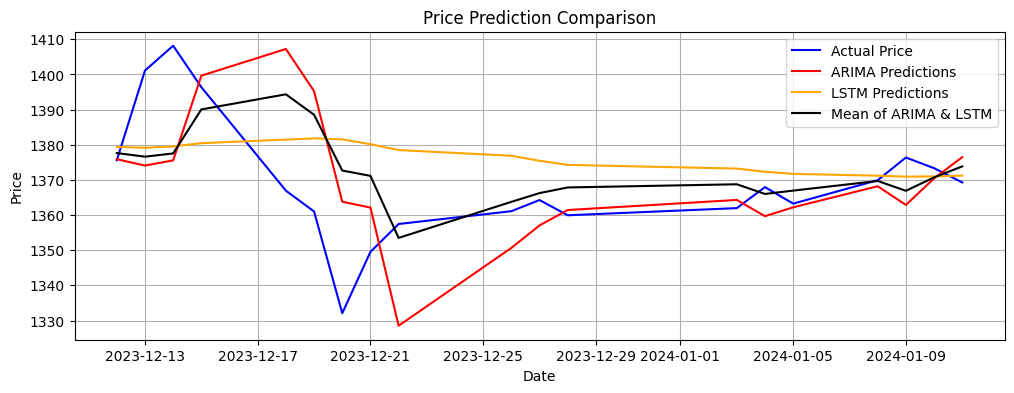

ARIMA MAE: 14.059658971422454 RMSE: 19.312674933658425 MAPE: 1.0270419929791597
LSTM MAE: 14.901193719161185 RMSE: 19.02693125023104 MAPE: 1.091507256014189
Mean Predictions MAE: 11.9185807455266 RMSE: 16.97683738904586 MAPE: 0.8713454273336008


In [140]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming 'predictions' is your ARIMA predictions, and 'test_pred' and 'real_test' are numpy arrays from LSTM predictions and actual data.
SET50_ARIMA = predictions
SET50_LSTM = test_pred.flatten().tolist()
SET50_REAL = real_test.flatten().tolist()  # This should be actual prices, confirm the variable name

# Truncate data to match the shortest series length for proper comparison
min_length = min(len(SET50_ARIMA), len(SET50_LSTM), len(DATE_SET50))
SET50_ARIMA_PLOT = SET50_ARIMA[:min_length]
SET50_LSTM_PLOT = SET50_LSTM[:min_length]
SET50_REAL_PLOT = SET50_REAL[:min_length]

# Compute mean predictions
SET50_MEAN_PLOT = [(a + b) / 2 for a, b in zip(SET50_ARIMA_PLOT, SET50_LSTM_PLOT)]

# Plotting the results
plt.figure(figsize=(12, 4))
plt.plot(SET50.iloc[:min_length].index, SET50_REAL_PLOT, label='Actual Price', color='blue')
plt.plot(SET50.iloc[:min_length].index, SET50_ARIMA_PLOT, color='red', label='ARIMA Predictions')
plt.plot(SET50.iloc[:min_length].index, SET50_LSTM_PLOT, color='orange', label='LSTM Predictions')
plt.plot(SET50.iloc[:min_length].index, SET50_MEAN_PLOT, color='black', label='Mean of ARIMA & LSTM')
plt.title('Price Prediction Comparison')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Calculation of MAE, RMSE, and MAPE
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((np.array(actual) - np.array(predicted)) / np.array(actual))) * 100
    return mae, rmse, mape

mae_arima, rmse_arima, mape_arima = calculate_metrics(SET50_REAL_PLOT, SET50_ARIMA_PLOT)
mae_lstm, rmse_lstm, mape_lstm = calculate_metrics(SET50_REAL_PLOT, SET50_LSTM_PLOT)
mae_mean, rmse_mean, mape_mean = calculate_metrics(SET50_REAL_PLOT, SET50_MEAN_PLOT)

print("ARIMA MAE:", mae_arima, "RMSE:", rmse_arima, "MAPE:", mape_arima)
print("LSTM MAE:", mae_lstm, "RMSE:", rmse_lstm, "MAPE:", mape_lstm)
print("Mean Predictions MAE:", mae_mean, "RMSE:", rmse_mean, "MAPE:", mape_mean)


# GOLD ARIMA

In [141]:
arima_model(GOLD)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=874.969, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=876.789, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=876.819, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=877.002, Time=0.00 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=878.720, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.238 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  103
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -435.484
Date:                Sun, 12 May 2024   AIC                            874.969
Time:                        22:45:05   BIC                            880.219
Sample:                             0   HQIC                           877.095
                    

In [142]:
# Split data into train and test sets
X = GOLD.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

# Walk-forward validation
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    # Generate a prediction
    yhat = arima_forecast(history)
    predictions.append(yhat)
    # Add the predicted value to the training set
    obs = test[t]
    history.append(obs)

[2333.3126958]
[2362.18409115]
[2361.91404596]
[2371.69869434]
[2399.55501672]
[2375.49993287]
[2387.01146794]
[2404.85539055]
[2328.40187771]
[2324.28681023]
[2321.56458883]
[2328.18613632]
[2334.06156763]
[2345.85058086]
[2286.78584903]
[2297.27087513]
[2297.05050918]
[2297.26916771]
[2322.05948429]
[2315.3923789]
[2313.58616265]


# GOLD LSTM

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.2506
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1849
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.1243
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0702
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0278
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0070
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0196
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0457
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0483
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0342
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0189
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0097
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0070
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0087
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0123
Epoch 16/100
1/1 ━━━━

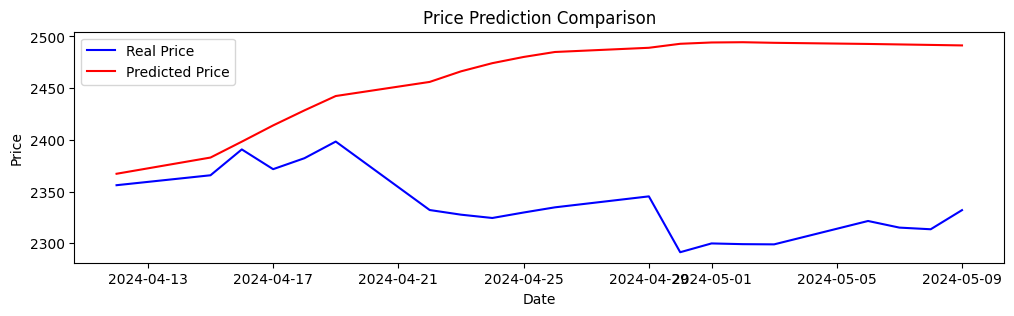

In [143]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

def prepare_data(data, n_features):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    X = []
    y = []
    dates = []
    for i in range(60, len(scaled_data)):  # Starting from day 60
        X.append(scaled_data[i-60:i, 0])
        y.append(scaled_data[i, 0])
        dates.append(data.index[i])
    X, y, dates = np.array(X), np.array(y), np.array(dates)

    if X.shape[0] == 0:
        return None, None, None, None, None, None

    X = np.reshape(X, (X.shape[0], X.shape[1], n_features))
    
    # Modify where to split for train and test to ensure alignment with ARIMA start
    split_point = len(X) - int(0.2 * len(data))  # Make test set size 20% of the entire dataset, not the reduced (data-60 days)
    X_train, X_test = X[:split_point], X[split_point:]
    y_train, y_test = y[:split_point], y[split_point:]
    train_dates, test_dates = dates[:split_point], dates[split_point:]

    return X_train, y_train, X_test, y_test, scaler, test_dates

# Rest of the code remains the same.


def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def plot_predictions(dates, real, predicted):
    plt.figure(figsize=(12, 3))
    plt.plot(dates, real, color='blue', label='Real Price')
    plt.plot(dates, predicted, color='red', label='Predicted Price')
    plt.title('Price Prediction Comparison')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

data = GOLD[['Close']]
X_train, y_train, X_test, y_test, scaler, test_dates = prepare_data(data, n_features=1)

if X_train is None:
    print("Not enough data to create any training samples. Check your data source or reduce the timestep window.")
else:
    model = build_lstm_model(input_shape=(X_train.shape[1], 1))
    model.fit(X_train, y_train, epochs=100, batch_size=32)

    test_pred = model.predict(X_test)
    test_pred = scaler.inverse_transform(test_pred)
    real_test = scaler.inverse_transform(y_test.reshape(-1,1))

# GOLD Mean

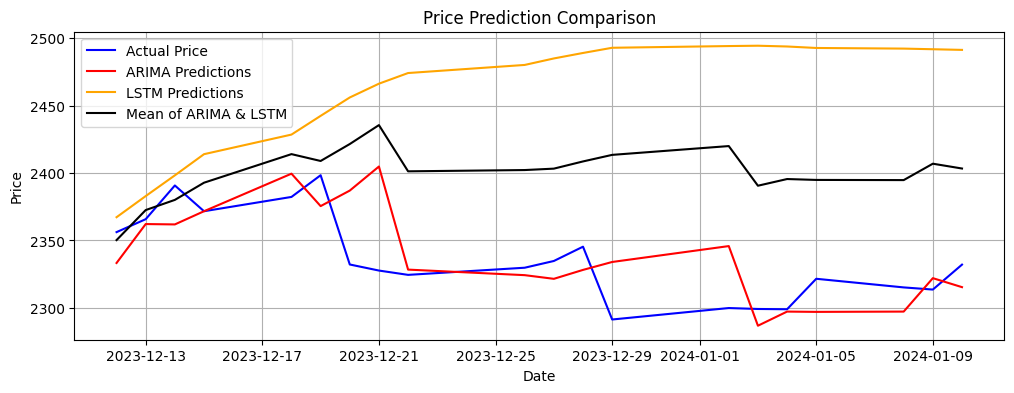

ARIMA MAE: 21.888987837108903 RMSE: 29.18159334387606 MAPE: 0.9385323271230049
LSTM MAE: 124.8204345703125 RMSE: 141.6643792089066 MAPE: 5.377700397144771
Mean Predictions MAE: 65.63603788759895 RMSE: 75.41073361196894 MAPE: 2.8285237843001383


In [144]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming 'predictions' is your ARIMA predictions, and 'test_pred' and 'real_test' are numpy arrays from LSTM predictions and actual data.
GOLD_ARIMA = predictions
GOLD_LSTM = test_pred.flatten().tolist()
GOLD_REAL = real_test.flatten().tolist()  # This should be actual prices, confirm the variable name

# Truncate data to match the shortest series length for proper comparison
min_length = min(len(GOLD_ARIMA), len(GOLD_LSTM), len(GOLD_REAL))
GOLD_ARIMA_PLOT = GOLD_ARIMA[:min_length]
GOLD_LSTM_PLOT = GOLD_LSTM[:min_length]
GOLD_REAL_PLOT = GOLD_REAL[:min_length]

# Compute mean predictions
GOLD_MEAN_PLOT = [(a + b) / 2 for a, b in zip(GOLD_ARIMA_PLOT, GOLD_LSTM_PLOT)]

# Plotting the results
plt.figure(figsize=(12, 4))
plt.plot(GOLD.iloc[:min_length].index, GOLD_REAL_PLOT, label='Actual Price', color='blue')
plt.plot(GOLD.iloc[:min_length].index, GOLD_ARIMA_PLOT, color='red', label='ARIMA Predictions')
plt.plot(GOLD.iloc[:min_length].index, GOLD_LSTM_PLOT, color='orange', label='LSTM Predictions')
plt.plot(GOLD.iloc[:min_length].index, GOLD_MEAN_PLOT, color='black', label='Mean of ARIMA & LSTM')
plt.title('Price Prediction Comparison')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Calculation of MAE, RMSE, and MAPE
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((np.array(actual) - np.array(predicted)) / np.array(actual))) * 100
    return mae, rmse, mape

mae_arima, rmse_arima, mape_arima = calculate_metrics(GOLD_REAL_PLOT, GOLD_ARIMA_PLOT)
mae_lstm, rmse_lstm, mape_lstm = calculate_metrics(GOLD_REAL_PLOT, GOLD_LSTM_PLOT)
mae_mean, rmse_mean, mape_mean = calculate_metrics(GOLD_REAL_PLOT, GOLD_MEAN_PLOT)

print("ARIMA MAE:", mae_arima, "RMSE:", rmse_arima, "MAPE:", mape_arima)
print("LSTM MAE:", mae_lstm, "RMSE:", rmse_lstm, "MAPE:", mape_lstm)
print("Mean Predictions MAE:", mae_mean, "RMSE:", rmse_mean, "MAPE:", mape_mean)


# OIL ARIMA

In [145]:
arima_model(OIL)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=332.415, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=328.644, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=329.822, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=329.962, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=327.428, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=329.123, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.146 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  103
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -162.714
Date:                Sun, 12 May 2024   AIC                            327.428
Time:                        22:50:08   BIC                            330.053
Sample:                             0   HQIC                           328.491
                

In [148]:
# Split data into train and test sets
X = OIL.values
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

# Walk-forward validation
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    # Generate a prediction
    yhat = arima_forecast(history)
    predictions.append(yhat)
    # Add the predicted value to the training set
    obs = test[t]
    history.append(obs)

[86.08871606]
[85.1834581]
[85.53505619]
[85.48066724]
[85.3435779]
[82.98427511]
[82.4657316]
[83.34876026]
[82.67723692]
[83.49147162]
[82.71471104]
[83.62520333]
[83.78686592]
[82.76272286]
[81.85768281]
[79.19591545]
[78.77212597]
[78.31722126]
[78.2694302]
[78.57925428]
[78.77436758]


# OIL LSTM

In [149]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

def prepare_data(data, n_features):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    X = []
    y = []
    dates = []
    for i in range(60, len(scaled_data)):  # Starting from day 60
        X.append(scaled_data[i-60:i, 0])
        y.append(scaled_data[i, 0])
        dates.append(data.index[i])
    X, y, dates = np.array(X), np.array(y), np.array(dates)

    if X.shape[0] == 0:
        return None, None, None, None, None, None

    X = np.reshape(X, (X.shape[0], X.shape[1], n_features))
    
    # Modify where to split for train and test to ensure alignment with ARIMA start
    split_point = len(X) - int(0.2 * len(data))  # Make test set size 20% of the entire dataset, not the reduced (data-60 days)
    X_train, X_test = X[:split_point], X[split_point:]
    y_train, y_test = y[:split_point], y[split_point:]
    train_dates, test_dates = dates[:split_point], dates[split_point:]

    return X_train, y_train, X_test, y_test, scaler, test_dates

# Rest of the code remains the same.


def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

data = OIL[['Close']]
X_train, y_train, X_test, y_test, scaler, test_dates = prepare_data(data, n_features=1)

if X_train is None:
    print("Not enough data to create any training samples. Check your data source or reduce the timestep window.")
else:
    model = build_lstm_model(input_shape=(X_train.shape[1], 1))
    model.fit(X_train, y_train, epochs=100, batch_size=32)

    test_pred = model.predict(X_test)
    test_pred = scaler.inverse_transform(test_pred)
    real_test = scaler.inverse_transform(y_test.reshape(-1,1))

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.7829
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.6431
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.5225
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.4135
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.3128
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.2192
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1343
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0634
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0172
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0126
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0532
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0863
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0822
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0571
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0311
Epoch 16/100
1/1 ━━━━

# OIL Mean

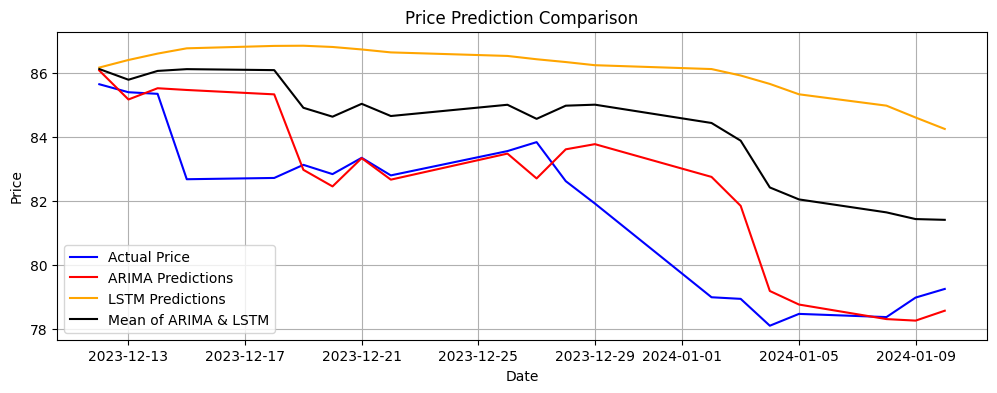

ARIMA MAE: 1.024848495596931 RMSE: 1.5111465668686448 MAPE: 1.2654009368498342
LSTM MAE: 4.267135238647461 RMSE: 4.717535578485664 MAPE: 5.2899633110052555
Mean Predictions MAE: 2.466569630735384 RMSE: 2.842572032975077 MAPE: 3.0582182482586218


In [151]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming 'predictions' is your ARIMA predictions, and 'test_pred' and 'real_test' are numpy arrays from LSTM predictions and actual data.
OIL_ARIMA = predictions
OIL_LSTM = test_pred.flatten().tolist()
OIL_REAL = real_test.flatten().tolist()  # This should be actual prices, confirm the variable name

# Truncate data to match the shortest series length for proper comparison
min_length = min(len(OIL_ARIMA), len(OIL_LSTM), len(OIL_REAL))
OIL_ARIMA_PLOT = OIL_ARIMA[:min_length]
OIL_LSTM_PLOT = OIL_LSTM[:min_length]
OIL_REAL_PLOT = OIL_REAL[:min_length]

# Compute mean predictions
OIL_MEAN_PLOT = [(a + b) / 2 for a, b in zip(OIL_ARIMA_PLOT, OIL_LSTM_PLOT)]

# Plotting the results
plt.figure(figsize=(12, 4))
plt.plot(OIL.iloc[:min_length].index, OIL_REAL_PLOT, label='Actual Price', color='blue')
plt.plot(OIL.iloc[:min_length].index, OIL_ARIMA_PLOT, color='red', label='ARIMA Predictions')
plt.plot(OIL.iloc[:min_length].index, OIL_LSTM_PLOT, color='orange', label='LSTM Predictions')
plt.plot(OIL.iloc[:min_length].index, OIL_MEAN_PLOT, color='black', label='Mean of ARIMA & LSTM')
plt.title('Price Prediction Comparison')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Calculation of MAE, RMSE, and MAPE
def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((np.array(actual) - np.array(predicted)) / np.array(actual))) * 100
    return mae, rmse, mape

mae_arima, rmse_arima, mape_arima = calculate_metrics(OIL_REAL_PLOT, OIL_ARIMA_PLOT)
mae_lstm, rmse_lstm, mape_lstm = calculate_metrics(OIL_REAL_PLOT, OIL_LSTM_PLOT)
mae_mean, rmse_mean, mape_mean = calculate_metrics(OIL_REAL_PLOT, OIL_MEAN_PLOT)

print("ARIMA MAE:", mae_arima, "RMSE:", rmse_arima, "MAPE:", mape_arima)
print("LSTM MAE:", mae_lstm, "RMSE:", rmse_lstm, "MAPE:", mape_lstm)
print("Mean Predictions MAE:", mae_mean, "RMSE:", rmse_mean, "MAPE:", mape_mean)

# SET50 Prophet

20:45:48 - cmdstanpy - INFO - Chain [1] start processing
20:45:48 - cmdstanpy - INFO - Chain [1] done processing


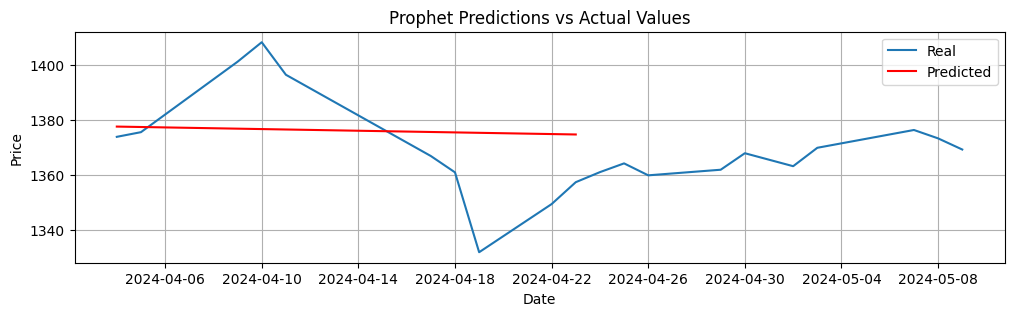

In [23]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming SET50 is your DataFrame and it has a 'Date' and 'Close' columns

# Prepare data for Prophet
df = pd.DataFrame()
df['ds'] = SET50.index  # Ensure this is datetime
df['y'] = SET50['Close'].values
# df
# len(df)
# Split data into train and test sets
size = int(len(df) * 0.8)
train = df.iloc[:size]
test = df.iloc[size:]

# Fit the Prophet model
model = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False)
model.fit(train)

# Make a future dataframe for predictions
future = model.make_future_dataframe(periods=len(test), freq='D', include_history=False)

# Predict
forecast = model.predict(future)
len(forecast)
# Plot
plt.figure(figsize=(12, 3))
plt.plot(df['ds'][size:], df['y'][size:], label='Real')
plt.plot(forecast['ds'], forecast['yhat'], color='red', label='Predicted')

plt.title('Prophet Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Date formatting on X-axis
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))

plt.grid(True)
plt.show()

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100 if np.any(y_true) else float('inf')

# Ensure that you have the 'test' DataFrame and 'forecast' DataFrame ready
# Extract actual and predicted values
actual = test['y'].values
predicted = forecast['yhat'][size:].values  # Adjust index if necessary

# Calculate MAE
mae = mean_absolute_error(actual, predicted)
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual, predicted))
# Calculate MAPE
mape = calculate_mape(actual, predicted)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


ValueError: Found input variables with inconsistent numbers of samples: [20, 0]

20:10:23 - cmdstanpy - INFO - Chain [1] start processing
20:10:23 - cmdstanpy - INFO - Chain [1] done processing


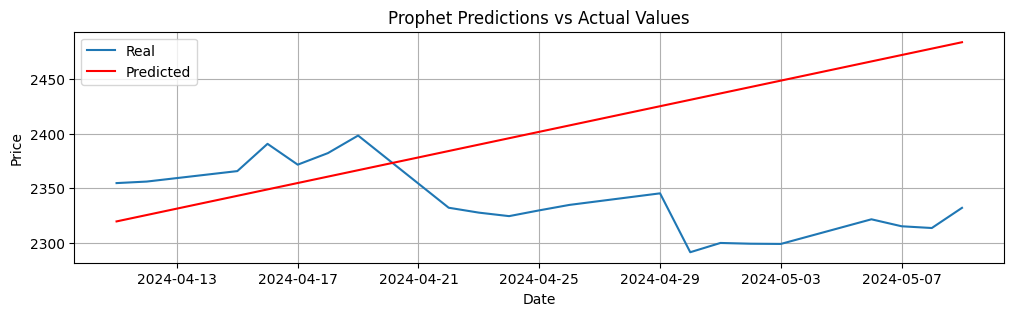

In [15]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming SET50 is your DataFrame and it has a 'Date' and 'Close' columns

# Prepare data for Prophet
df = pd.DataFrame()
df['ds'] = GOLD.index  # Ensure this is datetime
df['y'] = GOLD['Close'].values
# df
# len(df)
# Split data into train and test sets
size = int(len(df) * 0.8)
train = df.iloc[:size]
test = df.iloc[size:]

# Fit the Prophet model
model = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False)
model.fit(train)

# Make a future dataframe for predictions
future = model.make_future_dataframe(periods=29, freq='D', include_history=False)

# Predict
forecast = model.predict(future)
len(forecast)
# Plot
plt.figure(figsize=(12, 3))
plt.plot(df['ds'][size:], df['y'][size:], label='Real')
plt.plot(forecast['ds'], forecast['yhat'], color='red', label='Predicted')

plt.title('Prophet Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Date formatting on X-axis
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))

plt.grid(True)
plt.show()

20:11:11 - cmdstanpy - INFO - Chain [1] start processing
20:11:11 - cmdstanpy - INFO - Chain [1] done processing


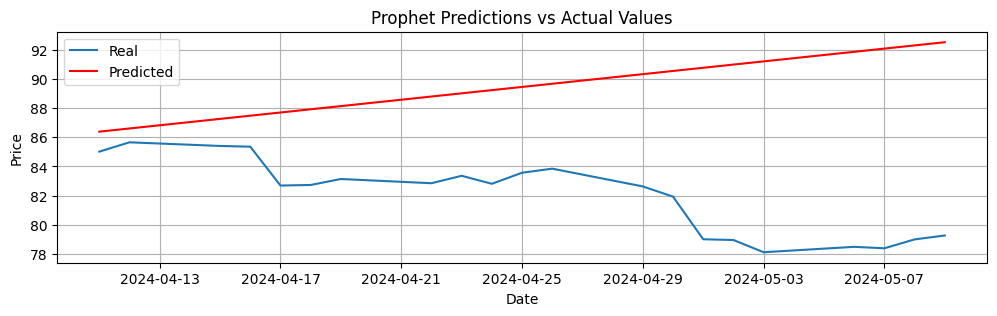

In [17]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Assuming SET50 is your DataFrame and it has a 'Date' and 'Close' columns

# Prepare data for Prophet
df = pd.DataFrame()
df['ds'] = OIL.index  # Ensure this is datetime
df['y'] = OIL['Close'].values
# df
# len(df)
# Split data into train and test sets
size = int(len(df) * 0.8)
train = df.iloc[:size]
test = df.iloc[size:]

# Fit the Prophet model
model = Prophet(daily_seasonality=False, weekly_seasonality=False, yearly_seasonality=False)
model.fit(train)

# Make a future dataframe for predictions
future = model.make_future_dataframe(periods=29, freq='D', include_history=False)

# Predict
forecast = model.predict(future)
len(forecast)
# Plot
plt.figure(figsize=(12, 3))
plt.plot(df['ds'][size:], df['y'][size:], label='Real')
plt.plot(forecast['ds'], forecast['yhat'], color='red', label='Predicted')

plt.title('Prophet Predictions vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Date formatting on X-axis
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=4))

plt.grid(True)
plt.show()